
# Big Mart Sales Prediction
By Patrick Kong

[Website](pkong97.github.io) | [Github](https://github.com/pkong97) | [LinkedIn](https://www.linkedin.com/in/pkong97/)


## <u>Contents:</u>

### <a href="#sec 1"><u>Section 1. Introduction</u></a>
1. Background
2. Questions

### <a href="#sec 2"><u>Section 2. Data</u></a>
1. Data source
2. Data cleaning
3. Replace missing and impossible values

### <a href="#sec 3"><u>Section 3. Exploratory Data Analysis</u></a>
1. Correlation matrix and heatmap
2. Important variables

### <a href="#sec 4"><u>Section 4. Model Fitting</u></a>
1. Change categorical variables into numerical variables
2. Mean-based model
3. Linear regression model
4. Ridge regression model
5. Decision tree model
6. Random frest model

### <a href="#sec 5"><u>Section 5. Conclusion</u></a>

### <div id="sec 1"><u>Section 1. Introduction</u></div>

**1. Background**

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

**2. Questions**

Based on the data, I would like to answer the following questions:
* Location type: What impact does the tier (ie. size of the city) of a location have on an item's sales?
* Outlet size and type: What impact does the size and type of the outlet have on an item's sales?
* Product visibility: How does the placement of an item in store affect its sales?


### <div id="sec 2"><u>Section 2. Data</u></div>

**1. Data source**

The for this case study was given by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/#ProblemStatement).

The train.csv dataset will be used to train a regression model which will be tested on the test.csv dataset.

**Preview of the training dataset**

The dataset contains items that BigMart sells with information about its qualities, sales, and where it is sold.

In [2]:
# Load appropriate libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("train.csv")
train.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


**2. Data cleaning**

There are many missing values in the columns "Item_Weight" and "Outlet_Size".

In [4]:
train.apply(lambda x: sum(x.isnull()), axis = 0)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


"Item_Visibility" has a minimum value of 0 which is impossible - an item cannot be invisible when sold in a store.
"Outlet_Establishment_Year" ranges from 1985 to 2009 which can be converted to how old the store is instead.

In [5]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
#Fix impossible minimum values of 0 in item visibility
avg_vis = train.pivot_table(values='Item_Visibility', index='Item_Identifier', aggfunc=np.mean)

#Replace 0 values with mean visibility of that product
for i in range(0, len(train['Item_Visibility'])):
    curr_item = train.loc[i, ('Item_Identifier')]
    if train.loc[i, ('Item_Visibility')] == 0:
        train.loc[i, ('Item_Visibility')] = avg_vis['Item_Visibility'][curr_item]

print('Number of 0 values after modification: ' + str(sum(train['Item_Visibility'] ==0)))

Number of 0 values after modification: 0


The "Item_Fat_Content" variable has "Low Fat" additionally labelled as "LF" and "low fat". "Regular" is also mislabelled as "reg".

In [7]:
train['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

**3. Replace missing and impossible values**

We replace the missing values in the "Item_Weights" column with the mean of that item type.

In [8]:
# Replace missing values in Item_Weights
mean_weights = train.pivot_table(values = 'Item_Weight', index = ['Item_Type'], aggfunc = np.mean)
for i in range(0, len(train['Item_Type'])):
    curr_item = train.loc[i, ('Item_Type')]
    if train['Item_Weight'].isna()[i]:
        train.loc[i, ('Item_Weight')] = mean_weights['Item_Weight'][curr_item]

print('Number of missing values after modification: ' + str(sum(train['Item_Weight'].isnull())))

Number of missing values after modification: 0


We replace the missing values in the "Outlet_Size" column according to the most frequent outlet type.

Based on the pivot table below, if the outlet type is:
* Supermarket Type 2 or 3, the outlet size is 'Medium'
* Supermarket Type 1, the outlet size is 'Small'
* Grocerhy Store, the outlet size is 'Small'

In [9]:
train.pivot_table(values='Outlet_Location_Type', index = 'Outlet_Size', columns=['Outlet_Type'], aggfunc='count')

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,NaN,932.0,NaN,NaN
Medium,NaN,930.0,928.0,935.0
Small,528.0,1860.0,NaN,NaN


In [10]:
# Replace missing values in 'Outlet_Size' according to mode of 'Outlet_Type'

for i in range(0, len(train['Outlet_Type'])):
    curr_type = train.loc[i, ('Outlet_Type')]
    if train['Outlet_Size'].isna()[i]:
        if curr_type == 'Supermarket Type(2|3)':
            train.loc[i, ('Outlet_Size')] = 'Medium'
        else:
            train.loc[i, ('Outlet_Size')] = 'Small'

print('Number of missing values after modification: ' + str(sum(train['Outlet_Size'].isnull())))

Number of missing values after modification: 0


We replace the following:
* 'LF' and 'low fat' with 'Low Fat'
* 'reg' with 'Regular'

In [11]:
#Fix mislabellings in fat content
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'})
train['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

We adjust the outlet establishment year to represent the age of the outlet in years.

In [12]:
#Adjust outlet establishment year to age
train['Outlet_Age'] = 2013 - train['Outlet_Establishment_Year']
train['Outlet_Age'].describe()
train.drop(['Outlet_Establishment_Year'], axis = 1, inplace = True)

Check missing values

In [13]:
# No more missing values
train.apply(lambda x: sum(x.isnull()), axis = 0)

Item_Identifier         0
Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
Outlet_Age              0
dtype: int64

**Clean Test Data**

We apply all the data-cleaning procedures on the training dataset to the test dataset.

In [14]:
test = pd.read_csv('test.csv')
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'})

avg_vis2 = test.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Replace 0 values with mean visibility of that product
for i in range(0, len(test['Item_Visibility'])):
    curr_item = test.loc[i, ('Item_Identifier')]
    if test.loc[i, ('Item_Visibility')] == 0:
        test.loc[i, ('Item_Visibility')] = avg_vis2['Item_Visibility'][curr_item]

mean_weights = test.pivot_table(values = 'Item_Weight', index = ['Item_Type'], aggfunc = np.mean)
for i in range(0, len(test['Item_Type'])):
    curr_item = test.loc[i, ('Item_Type')]
    if test['Item_Weight'].isna()[i]:
        test.loc[i, ('Item_Weight')] = mean_weights['Item_Weight'][curr_item]
        

for i in range(0, len(test['Outlet_Type'])):
    curr_type = test.loc[i, ('Outlet_Type')]
    if test['Outlet_Size'].isna()[i]:
        if curr_type == 'Supermarket Type(2|3)':
            test.loc[i, ('Outlet_Size')] = 'Medium'
        else:
            test.loc[i, ('Outlet_Size')] = 'Small'

print('Number of missing values after modification: ' + str(sum(test['Outlet_Size'].isnull())))

#Adjust outlet establishment year to age
test['Outlet_Age'] = 2013 - test['Outlet_Establishment_Year']
test.drop(['Outlet_Establishment_Year'], axis = 1, inplace = True)

Number of missing values after modification: 0


### <div id="sec 3"><u>Section 3. Exploratory Data Analysis</u></div>

**1. Correlation Matrix and Heatmap**

The variables "Item_MRP", "Outlet_Type", and "Outlet_Age" have the strongest positive correlations with our predictor "Item_Outlet_Sales".

In [15]:
train_corr = train.corr()
train_corr

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age
Item_Weight,1.000000,-0.018053,0.025821,0.012088,0.008376
Item_Visibility,-0.018053,1.000000,-0.004525,-0.128449,0.075175
Item_MRP,0.025821,-0.004525,1.000000,0.567574,-0.005020
Item_Outlet_Sales,0.012088,-0.128449,0.567574,1.000000,0.049135
Outlet_Age,0.008376,0.075175,-0.005020,0.049135,1.000000


[Text(0.5, 1.0, 'Correlation Heatmap of Item Variables')]

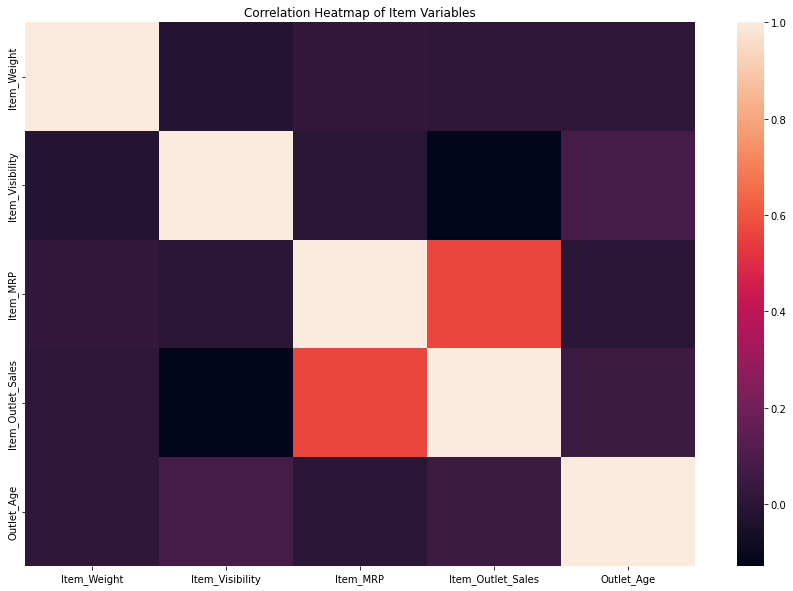

In [16]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values).set(title='Correlation Heatmap of Item Variables')

**2. Important variables**

Supermarket Type 3 has the highest average sales followed by supermarket type 1, supermarket type 2, and lastly, grocery stores.

In [17]:
outlet_type_sales = train.pivot_table(index="Outlet_Type", values="Item_Outlet_Sales", aggfunc=np.mean)
outlet_type_sales

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


"Item_MRP" has the strongest correlation with "Item_Outlet_sales" at 0.57. Here we see visualize the positive trend between "Item_MRP" and "Item_Outlet_Sales".

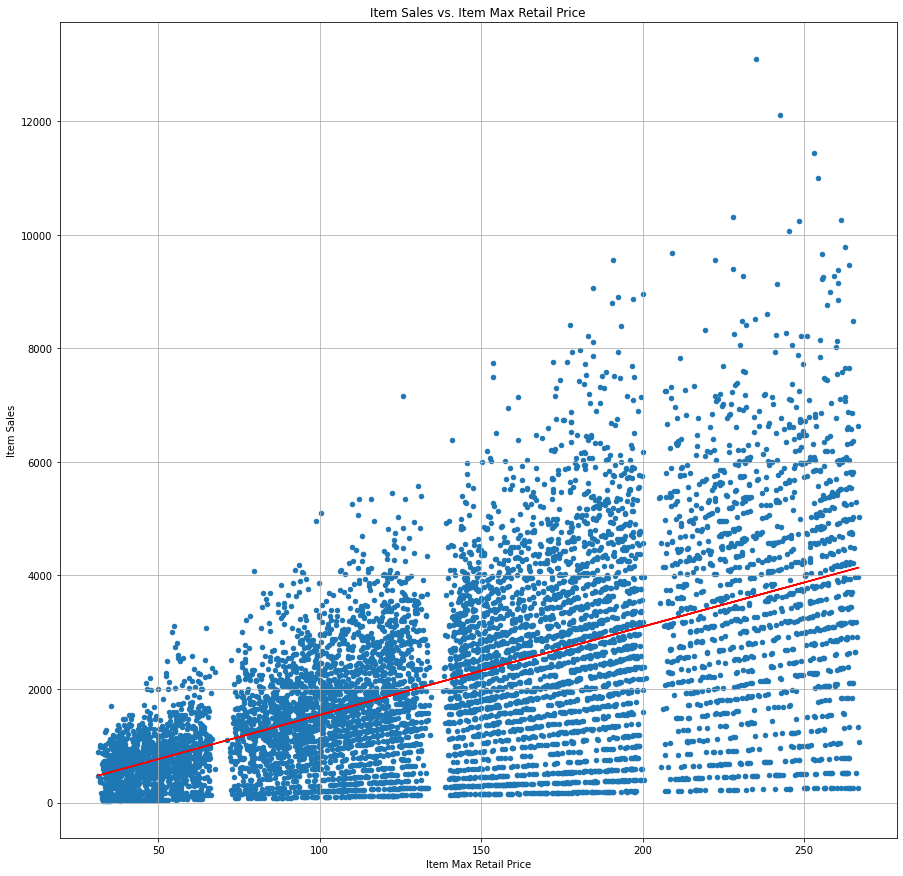

In [18]:
train.plot(x='Item_MRP', y='Item_Outlet_Sales', 
           kind='scatter', 
           title='Item Sales vs. Item Max Retail Price', 
           xlabel='Item Max Retail Price', ylabel="Item Sales", 
           grid=True,
           figsize=(15,15))

# Add trendline
z = np.polyfit(train['Item_MRP'], train['Item_Outlet_Sales'], 1)
p = np.poly1d(z)
plt.plot(train['Item_MRP'], p(train['Item_MRP']), color="red")


* "Outlet_Age" has a weak correlation with "Item_Outlet_Sales" at 0.049. Sales do not seem to vary much depending on the outlet age. 
* There also seems to be an outlier in that outlets of age 15 have much lower average sales.

<AxesSubplot:title={'center':'Average Item Sales of Outlets Based on Age'}, xlabel='Outlet Age (Years)', ylabel='Average Item Sales ($)'>

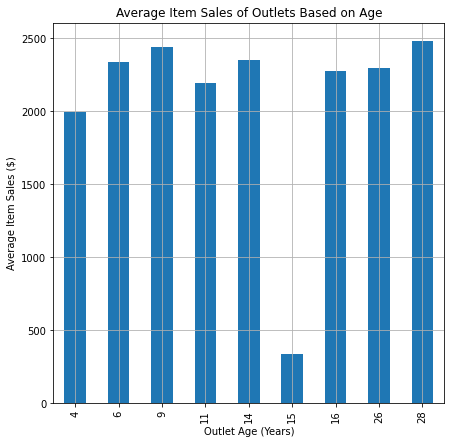

In [19]:
avg_sales_age = train.pivot_table(index='Outlet_Age', values='Item_Outlet_Sales', aggfunc=np.mean)
avg_sales_age.plot(
           kind='bar', 
           title='Average Item Sales of Outlets Based on Age', 
           xlabel='Outlet Age (Years)', ylabel="Average Item Sales ($)", 
           grid=True,
           figsize=(7,7),
           legend=False)
 

We see that all the outlets of age 15 years are grocery stores. We know from above that grocery stores have the least amount of average sales. We will keep these values as is.

In [20]:
train[train.Outlet_Age == 15].Outlet_Type.value_counts()

Grocery Store    555
Name: Outlet_Type, dtype: int64

### <div id="sec 4"><u>Section 4. Model Fitting</u></div>

**1. Change categorical variables into numerical variables**

Scikit-learn only accepts numerical variables, therefore we convert all the categorical and nominal variables into numeric types.

In [21]:
#Transform all categorical variables into numerics
from sklearn.preprocessing import LabelEncoder
var_mod = ['Item_Fat_Content','Item_Type', 'Outlet_Size',
          'Outlet_Location_Type', 'Outlet_Type']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])
train.dtypes

Item_Identifier          object
Item_Weight             float64
Item_Fat_Content          int32
Item_Visibility         float64
Item_Type                 int32
Item_MRP                float64
Outlet_Identifier        object
Outlet_Size               int32
Outlet_Location_Type      int32
Outlet_Type               int32
Item_Outlet_Sales       float64
Outlet_Age                int64
dtype: object

**2. Mean-based model**

First we fit a mean-based model to get a baseline prediction.

Uploading this dataset to Analytics Vidhya's solution checker gives the following score:

Public LB Score = 1773.83 (lower is better)

In [22]:
#Baseline model - Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

model1 = test.copy()
model1['Item_Outlet_Sales'] = mean_sales

#Export baseline model
model1.to_csv("mean-model.csv", index = False)

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold #For K-fold cross validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier', 'Outlet_Identifier']

def regression_model(model, train, test, predictors, target, IDcol, filename):
    model.fit(train[predictors], train[target])
    
    #Predict training set
    predictions = model.predict(train[predictors])
    
    #Cross validation
    cv_score = cross_val_score(model, train[predictors],
                                               train[target], cv = 20,
                                               scoring = 'neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    print("CV Score = " + str(np.mean(cv_score)))
    
    #Predict on test data:
    test[target] = model.predict(test[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({x: test[x] for x in IDcol})
    submission.to_csv(filename, index = False)

**3. Linear regression model**
<p>Public LB Score = 1271.42 </p>

CV Score = 1205.6279644382307


<AxesSubplot:title={'center':'Model Coefficients'}>

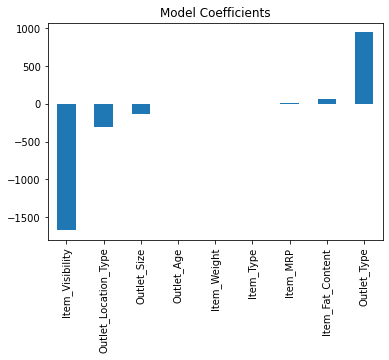

In [24]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
lm1 =LinearRegression(normalize = True)
regression_model(lm1, train, test, predictors, target, IDcol, 'lm1.csv')
coef1 = pd.Series(lm1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

**4. Ridge Regression model**
<p>Public LB Score = 1273.24</p>

CV Score = 1207.268600984918


<AxesSubplot:title={'center':'Model Coefficients'}>

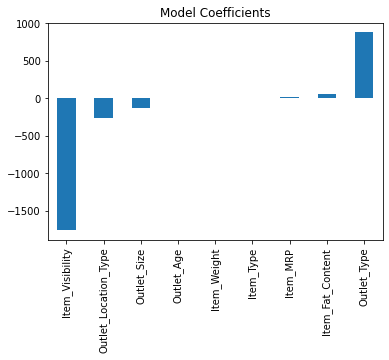

In [25]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
lm2 = Ridge(alpha=0.05,normalize=True)
regression_model(lm2, train, test, predictors, target, IDcol, 'lm2.csv')
coef2 = pd.Series(lm2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

**5. Decision tree model**
<p>Public LB Score = 1167.33 (Rank 965)</p>

We see that "Item_MRP", "Outlet_Type", and "Outlet_Age" are the most important features for the Decision tree model.

CV Score = 1088.7693871484626


<AxesSubplot:title={'center':'Feature Importances'}>

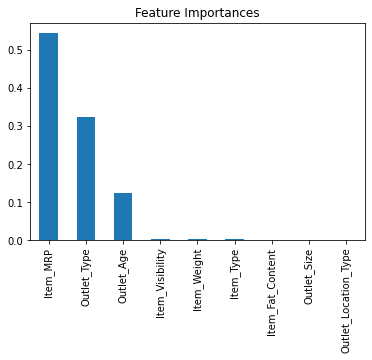

In [26]:
from sklearn.tree import DecisionTreeRegressor
lm3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf = 100)
regression_model(lm3, train, test, predictors, target, IDcol, 'lm3.csv')
coef3 = pd.Series(lm3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind = 'bar', title = 'Feature Importances')

**6. Random forest model**
<p>Public LB Score = 1154.16 (Rank 657 out of 2149)</p>

We see that "Item_MRP", "Outlet_Type", and "Outlet_Age" are the most important features for the Random Forest Model.

CV Score = 1082.8669304067994


<AxesSubplot:title={'center':'Feature Importances'}>

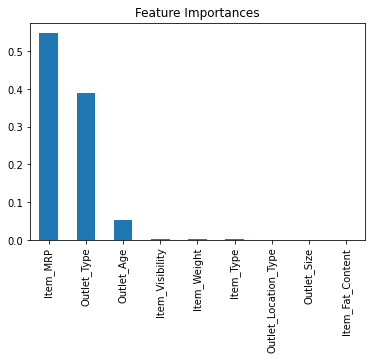

In [27]:
from sklearn.ensemble import RandomForestRegressor
lm4 = RandomForestRegressor(max_depth = 15, min_samples_leaf = 100)
regression_model(lm4, train, test, predictors, target, IDcol, 'lm4.csv')
coef4 = pd.Series(lm4.feature_importances_, predictors).sort_values(ascending = False)
coef4.plot(kind = 'bar', title = 'Feature Importances')

### <div id="sec 5"><u>Section 5. Conclusion</u></div>



The random forest model produced the best prediction score.

The overall consensus from model fitting and exploratory data analysis is that:
* item price, outlet type, and outlet age in descending order are the best predictors of an item's sales
* item visibility has almost no effect on the item's sales